In [133]:
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy import constants as const
import pandas as pd
from astropy.table import Column
from astropy.time import Time
from scipy import interpolate as interp
import time
# from Photoz import photoz_tools as phtz
from tractor import *
from skimage.transform import downscale_local_mean
import scipy.optimize as opt
import matplotlib as mpl
from scipy.spatial.distance import cdist

import itertools
import matplotlib.pyplot as plt
from astropy.table import hstack
import os

import SPHEREx_ObsSimulator as SPobs
from SPHEREx_Simulator_Tools import SPHEREx_Logger, data_filename
import SPHEREx_InstrumentSimulator as SPinst
import SPHEREx_SkySimulator as SPsky
from pkg_resources import resource_filename

# survey_plan_file = 'spherex_survey_plan_march_2021.fits'
survey_plan_file = "/Users/gemmahuai/Desktop/CalTech/SPHEREx/Redshift/spherex_survey_plan_R2.fits"
SPHEREx_Pointings = SPobs.Pointings(input_file = survey_plan_file,
                                   Gaussian_jitter=1.8, 
                                   roll_angle='psi2')

from spherex_parameters import load_spherex_parameters
# Load instrument and project parameters as a dictionary
spherex_parameters = load_spherex_parameters()


ds1 = 4
ds2 = 2
trim = 32
SPHEREx_Instrument = SPinst.Instrument(
    instrument_data=spherex_parameters,
    psf=data_filename("psf/simulated_PSF_database_centered_v3_og.fits"),
    psf_downsample_by_array={1: ds1, 2: ds1, 3: ds1, 4: ds2, 5: ds2, 6: ds2},
    psf_trim_by_array={1: trim, 2: trim, 3: trim, 4: trim, 5: trim, 6: trim},

    noise_model=SPinst.white_noise,
    dark_current_model=SPinst.poisson_dark_current,
    lvf_model=SPinst.Tabular_Bandpass()
)

from SPHEREx_SkySimulator import QuickCatalog
from SPHEREx_SkySimulator import Catalog_to_Simulate
# path='/Users/zhaoyuhuai/SPHEREx-Sky-Simulator/docs/QuickCatalog/'

from pyarrow import parquet
from astropy.table import Table
from astropy.io import fits
Channels = Table.read(data_filename('Channel_Definition_03022021.fits'))
Scene = SPsky.Scene(SPHEREx_Pointings,
                        zodi_model=SPsky.zodicalc.ModifiedKelsallModelWithHPFT())

COSMOS_tab = Table.read('/Users/gemmahuai/Desktop/CalTech/SPHEREx/SPHEREx_2023/COSMOS2020_FARMER_R1_v2.1_p3_in_Richard_sim_2023Dec4.fits', format='fits')
COSMOS_sim_sources = Table.read('/Users/gemmahuai/Desktop/CalTech/SPHEREx/SPHEREx_2023/COSMOS2020_FARMER_R1_v2.1_p3_in_Richard_sim_2023Dec4.fits', format='fits')



# Shuang-Shuang's deep field maps

In [134]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.coordinates import BarycentricMeanEcliptic, BarycentricTrueEcliptic
import healpy

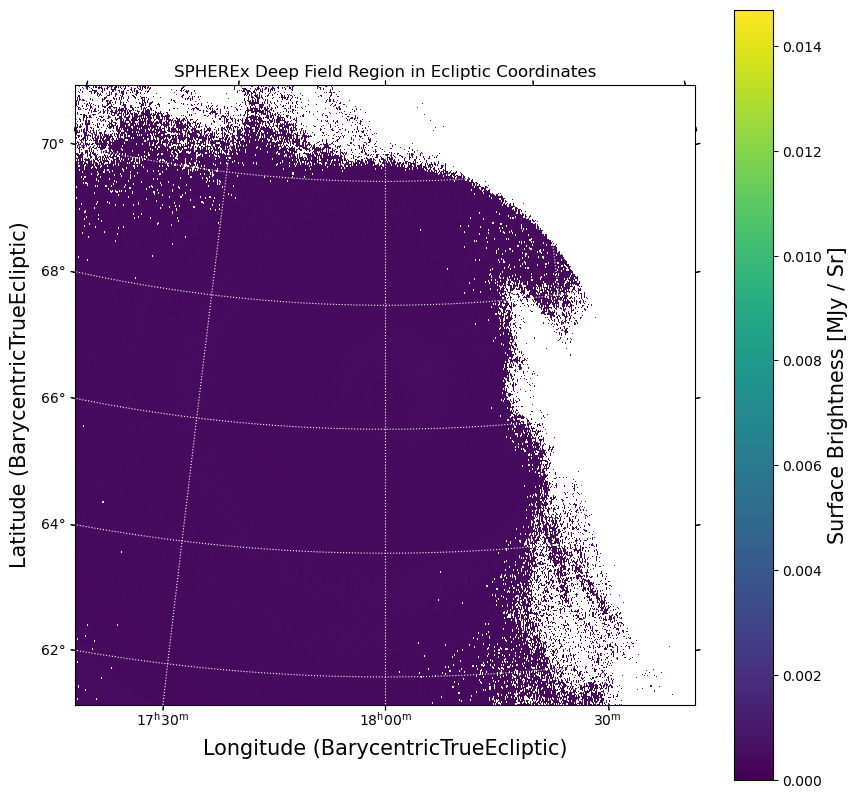

In [150]:

fits_file = "./maps/schen6/deep_north_dc.fits" 
with fits.open(fits_file) as hdul:
    data = hdul[0].data
    header = hdul[0].header

# extract wcs info
wcs = WCS(header)

# Step 3: Define the target coordinate frame
# Uncomment one of these based on the desired coordinate system
# target_frame = Galactic()  # For Galactic coordinates
target_frame = BarycentricTrueEcliptic()  # For Ecliptic coordinates

# Step 4: Plot the data in the desired coordinates
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs)  # Use projection=wcs directly here
ax.imshow(data, origin="lower", cmap="viridis")

# Step 5: Transform WCS to the target frame
ax.coords.grid(True, color="white", ls="dotted")
ax.coords[0].set_axislabel(f"Longitude ({target_frame.__class__.__name__})", fontsize=15)
ax.coords[1].set_axislabel(f"Latitude ({target_frame.__class__.__name__})", fontsize=15)
ax.set_title("SPHEREx Deep Field Region in Ecliptic Coordinates")

# Show the plot
cbar = plt.colorbar(ax.images[0], ax=ax)
cbar.set_label('Surface Brightness [MJy / Sr]', fontsize=15)
plt.show()


In [151]:
sr_per_pix = (header['CDELT1']*np.pi/180) * (header['CDELT2']*np.pi/180)


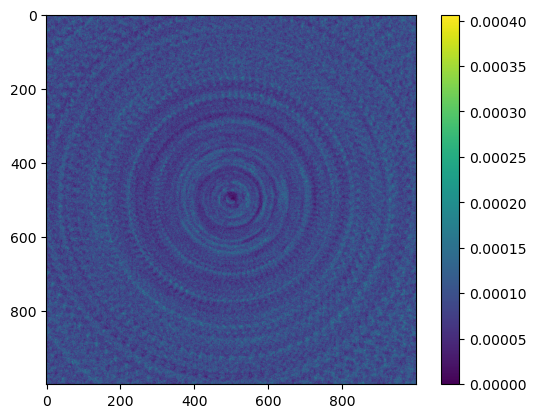

In [152]:
plt.imshow(data[5500:6500, 5500:6500] * sr_per_pix * 1e9)
plt.colorbar()

In [ ]:
0.002 * 

Text(0, 0.5, 'DEC (deg)')

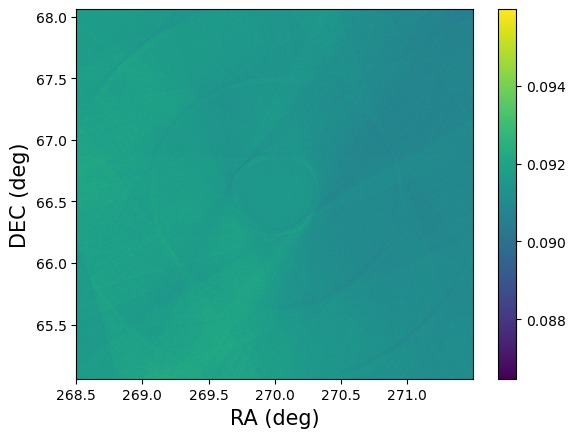

In [119]:
### ra, dec
ra_l = header['CRVAL1']-header['CDELT1']*1800
ra_h = header['CRVAL1']+header['CDELT1']*1800
dc_l = header['CRVAL2']-header['CDELT2']*1800
dc_h = header['CRVAL2']+header['CDELT2']*1800
extent = [ra_l, ra_h,
          dc_l, dc_h]

plt.imshow(data, aspect='auto', extent=extent)
plt.colorbar()
plt.xlabel("RA (deg)", fontsize=15)
plt.ylabel("DEC (deg)", fontsize=15)
# plt.xlim(268.5, 268.6)
# plt.ylim(67.5, 67.6)

In [125]:
### generate zodi map using Sky Simulator

wave = 0.75 * u.micrometer

zodi = SPsky.zodicalc.ModifiedKelsallModelWithHPFT()
times = '2024-12-10T00:00:00'
t = Time(times, format='isot', scale='utc')

RAs = np.linspace(ra_l, ra_h, 100)
DECs = np.linspace(dc_l, dc_h, 100)

(RAs, DECs) = np.meshgrid(RAs, DECs)

ZLs = np.zeros(shape=(100,100))
for i in range(RAs.shape[0]):
    for j in range(DECs.shape[1]):
        
        crd = SkyCoord(ra=RAs[i,j], dec=DECs[i,j], unit='degree')
        zl = zodi(t, crd, wave)
        ZLs[i,j] = zl
        



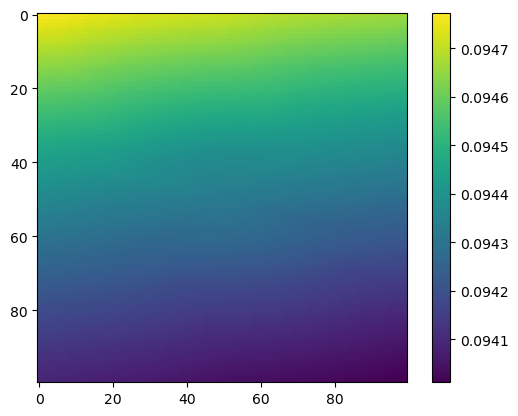

In [127]:
plt.imshow(ZLs)
plt.colorbar()